<a href="https://colab.research.google.com/github/eeyamazaki/soebe/blob/main/modelo_preditivo_soebe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
# Importando as bibliotecas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [180]:
# Lendo a base de reposicoes da SOEBE:

# skiprows = 3, pois as 3 primeiras linhas sao cabecalho.

dfSoebe = pd.read_csv(r'/content/drive/MyDrive/Projetos/soebe/pendentes-soebe/reposicoes.txt', encoding='cp1252', sep='|',
                      skiprows=3, dtype=object)
dfSoebe.head()

,Unnamed: 0,Ordem,Tipo ordem,Centro,Operação,CenTrab,Txt.breve operação,Cód. Único,Oper.ZSCP,TSE Oper.,...,Quantidade,Extensão,MND,L.Corte/Su,Religação,Mt.Cúbico,Observação,StatSist,StatUsuár.,Unnamed: 54
0,----------------------------------------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2206463343,ZSCP,0004,0050,277CRB04,REPOSIÇÃO DE ASFALTO INV,226463343,0050,733000,...,,"0,00",,,,,...,LIB,EXEC VALO,NaN
2,NaN,2207236897,ZSCP,0004,0040,273CRL07,SERVIÇO EXECUTADO ANTERIORMENTE,227236897,0040,904200,...,,"0,00",,,,,"Conforme vistoria em 06.08.22, servico executa...",LIB,NEXE VALO,NaN
3,NaN,2210680011,ZSCP,0004,0030,277CRB04,REPOSIÇÃO DE ASFALTO INV,2210680011,0030,733000,...,,"0,00",,,,,...,LIB,EXEC VALO,NaN
4,NaN,2212237908,ZSCP,0004,0050,273CRL10,REPOSIÇÃO DE CAPA ASFALTICA INV,2212237908,0050,745000,...,,"0,00",,,,,...,LIB,EXEC,NaN


In [181]:
# Como o cabecalho possui um excesso de espacos, vamos remover e renomea-los:

l1 = dfSoebe.columns
l1 = [x.strip(' ') for x in l1]

dfSoebe = dfSoebe.rename(columns=dict(zip(dfSoebe.columns, l1)))
dfSoebe.columns

Index(['Unnamed: 0', 'Ordem', 'Tipo ordem', 'Centro', 'Operação', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSE Oper.', 'TSS',
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Tipo Mat.', 'Pos. Rede', 'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.',
       'Comp.', 'Largura', 'Profund.', 'Quantidade', 'Extensão', 'MND',
       'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação', 'StatSist',
       'StatUsuár.', 'Unnamed: 54'],
      dtype='object')

In [182]:
# Removendo excesso de espacos em todas as colunas:

for i in l1:
  dfSoebe[i] = dfSoebe[i].str.strip()

In [183]:
#Missing Values:
#Temos apenas 2 missing values no dataframe.

dfSoebe = dfSoebe.dropna(subset=['Ordem'])

In [184]:
dfSoebe.head()

,Unnamed: 0,Ordem,Tipo ordem,Centro,Operação,CenTrab,Txt.breve operação,Cód. Único,Oper.ZSCP,TSE Oper.,...,Quantidade,Extensão,MND,L.Corte/Su,Religação,Mt.Cúbico,Observação,StatSist,StatUsuár.,Unnamed: 54
1,NaN,2206463343,ZSCP,0004,0050,277CRB04,REPOSIÇÃO DE ASFALTO INV,226463343,0050,733000,...,,"0,00",,,,,,LIB,EXEC VALO,NaN
2,NaN,2207236897,ZSCP,0004,0040,273CRL07,SERVIÇO EXECUTADO ANTERIORMENTE,227236897,0040,904200,...,,"0,00",,,,,"Conforme vistoria em 06.08.22, servico executa...",LIB,NEXE VALO,NaN
3,NaN,2210680011,ZSCP,0004,0030,277CRB04,REPOSIÇÃO DE ASFALTO INV,2210680011,0030,733000,...,,"0,00",,,,,,LIB,EXEC VALO,NaN
4,NaN,2212237908,ZSCP,0004,0050,273CRL10,REPOSIÇÃO DE CAPA ASFALTICA INV,2212237908,0050,745000,...,,"0,00",,,,,,LIB,EXEC,NaN
5,NaN,2213943855,ZSCP,0004,0020,277CRL06,DUPLICIDADE,2213943855,0020,901500,...,,"0,00",,,,,problema sistema,LIB,NEXE,NaN


In [185]:
dfSoebe.columns

Index(['Unnamed: 0', 'Ordem', 'Tipo ordem', 'Centro', 'Operação', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSE Oper.', 'TSS',
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Tipo Mat.', 'Pos. Rede', 'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.',
       'Comp.', 'Largura', 'Profund.', 'Quantidade', 'Extensão', 'MND',
       'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação', 'StatSist',
       'StatUsuár.', 'Unnamed: 54'],
      dtype='object')

In [186]:
dfSoebe = dfSoebe.drop(['Unnamed: 0', 'Tipo ordem', 'Centro', 'CenTrab', 'Txt.breve operação',
              'Cód. Único', 'Oper.ZSCP', 'TSS', 'Cont.ZSCP', 'M.Mão Obra',
              'Ag.Tp.Serv', 'Resp.ZSCP', 'DtDespacho', 'Dt.Início', 'Hr.Iniíio',
              'Dt.FimExec', 'Hr.Fim', 'Hr.Trab.', 'Acatamento', 'Hr.Acatam.',
              'Dt.Agend.', 'Turno', 'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.',
              'Dt.Fim', 'Hr.Fim  .1', 'H.Retirado', 'Instalado', 'Garantia',
              'Dt.Exec.', 'Hr.Exec.', 'Peso', 'Tipo Mat.', 'Pos. Rede',
              'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.', 'Quantidade', 'Extensão',
              'MND', 'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação',
              'Unnamed: 54'], axis=1)

dfSoebe.head()

,Ordem,Operação,TSE Oper.,Un. Adm.,Comp.,Largura,Profund.,StatSist,StatUsuár.
1,2206463343,0050,733000,277,"1,00","1,00","0,00",LIB,EXEC VALO
2,2207236897,0040,904200,273,"0,00","0,00","0,00",LIB,NEXE VALO
3,2210680011,0030,733000,277,"2,00","1,50","0,00",LIB,EXEC VALO
4,2212237908,0050,745000,273,"1,00","1,00","3,00",LIB,EXEC
5,2213943855,0020,901500,277,"0,00","0,00","0,00",LIB,NEXE


In [187]:
# Lendo a base de servicos liberados no SAP para o GLOBAL:

# skiprows = 3, pois as 3 primeiras linhas sao cabecalho.

dfGlobal = pd.read_csv(r'/content/drive/MyDrive/Projetos/soebe/pendentes-global/global.txt', 
                 encoding='cp1252', on_bad_lines='skip', skiprows=3, sep='|', dtype=object)

In [188]:
dfGlobal.head()

,Unnamed: 0,Ordem,Tipo ordem,Centro,Operação,CenTrab,Txt.breve operação,Cód. Único,Oper.ZSCP,TSE Oper.,...,Quantidade,Extensão,MND,L.Corte/Su,Religação,Mt.Cúbico,Observação,StatSist,StatUsuár.,Unnamed: 54
0,----------------------------------------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2110062824,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110062824,0010,903000,...,,"0,00",,,,,...,LIB,NEXE,NaN
2,NaN,2110063329,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110063329,0010,903000,...,,"0,00",,,,,...,LIB,NEXE,NaN
3,NaN,2110063740,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110063740,0010,903000,...,,"0,00",,,,,...,LIB,NEXE,NaN
4,NaN,2110064727,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110064727,0010,903000,...,,"0,00",,,,,...,LIB,NEXE,NaN


In [189]:
# Como o cabecalho possui um excesso de espacos, vamos remover e renomea-los:

l1 = dfGlobal.columns
l1 = [x.strip(' ') for x in l1]

dfGlobal = dfGlobal.rename(columns=dict(zip(dfGlobal.columns, l1)))

dfGlobal.columns

Index(['Unnamed: 0', 'Ordem', 'Tipo ordem', 'Centro', 'Operação', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSE Oper.', 'TSS',
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Tipo Mat.', 'Pos. Rede', 'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.',
       'Comp.', 'Largura', 'Profund.', 'Quantidade', 'Extensão', 'MND',
       'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação', 'StatSist',
       'StatUsuár.', 'Unnamed: 54'],
      dtype='object')

In [190]:
# Removendo o excesso de espacos no dataframe:

for i in l1:
  dfGlobal[i] = dfGlobal[i].str.strip()

In [191]:
#Missing Values:
#Temos apenas 2 missing values no dataframe.

dfGlobal = dfGlobal.dropna(subset=['Ordem'])

In [192]:
dfGlobal.head()

,Unnamed: 0,Ordem,Tipo ordem,Centro,Operação,CenTrab,Txt.breve operação,Cód. Único,Oper.ZSCP,TSE Oper.,...,Quantidade,Extensão,MND,L.Corte/Su,Religação,Mt.Cúbico,Observação,StatSist,StatUsuár.,Unnamed: 54
1,NaN,2110062824,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110062824,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN
2,NaN,2110063329,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110063329,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN
3,NaN,2110063740,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110063740,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN
4,NaN,2110064727,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110064727,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN
5,NaN,2110065051,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110065051,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN


In [193]:
dfGlobal.columns

Index(['Unnamed: 0', 'Ordem', 'Tipo ordem', 'Centro', 'Operação', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSE Oper.', 'TSS',
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Tipo Mat.', 'Pos. Rede', 'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.',
       'Comp.', 'Largura', 'Profund.', 'Quantidade', 'Extensão', 'MND',
       'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação', 'StatSist',
       'StatUsuár.', 'Unnamed: 54'],
      dtype='object')

In [194]:
dfGlobal = dfGlobal.drop(['Unnamed: 0', 'Tipo ordem', 'Centro', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSS', 
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Quantidade', 'Observação', 'Unnamed: 54', 'L.Corte/Su', 'Religação'], axis=1)

dfSoebe.head()

,Ordem,Operação,TSE Oper.,Un. Adm.,Comp.,Largura,Profund.,StatSist,StatUsuár.
1,2206463343,0050,733000,277,"1,00","1,00","0,00",LIB,EXEC VALO
2,2207236897,0040,904200,273,"0,00","0,00","0,00",LIB,NEXE VALO
3,2210680011,0030,733000,277,"2,00","1,50","0,00",LIB,EXEC VALO
4,2212237908,0050,745000,273,"1,00","1,00","3,00",LIB,EXEC
5,2213943855,0020,901500,277,"0,00","0,00","0,00",LIB,NEXE


In [195]:
# Quantidade de Ordens duplicadas:

len(dfGlobal['Ordem'])-dfGlobal['Ordem'].nunique()

14789

In [196]:
dfGlobal['StatUsuár.'].unique()

array(['NEXE', 'EXEC VALO', 'EXEC', 'NEXE VALO'], dtype=object)

In [197]:
dfGlobal['Ordem'].nunique()

45706

In [198]:
print(dfSoebe[dfSoebe['Ordem']=='2212237908'])

        Ordem Operação TSE Oper. Un. Adm. Comp. Largura Profund. StatSist  \
4  2212237908     0050    745000      273  1,00    1,00     3,00      LIB   

  StatUsuár.  
4       EXEC  


In [199]:
# Lendo o primeiro arquivo:

path = r'/content/drive/MyDrive/Projetos/soebe/servicos_pagos-soebe'
filenames = glob.glob(path + "/*.txt")

dfs = []
for filename in filenames:
  dfs.append(pd.read_csv(filename, dtype=object, encoding='cp1252', sep='|',
                      skiprows=8))

dfServPag = pd.concat(dfs, ignore_index=True)
dfServPag.head()

,Unnamed: 0,Un. Adm.,Frente,Ordem,Etapa,TSE,Descrição do TSE,Endereço,Município,Data Fim d,...,Fim,Unnamed: 37,Endereço,Descrição do Motivo de Não Pagamento,Endereço,Descrição,Pedido,Descrição do TSE,Endereço,Descrição do Motivo
0,----------------------------------------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,277,04,2206463343,0050,733000,REPOSIÇÃO DE ASFALTO INV,RUA MIGUEL OSORIO DE ALMEIDA 67 C/1 VL RENATO ...,SÃO PAULO,14.07.2022,...,31.07.2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,277,04,2210680011,0030,733000,REPOSIÇÃO DE ASFALTO INV,RUA JOAO RICARDO 40 C/1 JD PERI ...,SÃO PAULO,14.07.2022,...,31.07.2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,277,04,2218010936,0050,733000,REPOSIÇÃO DE ASFALTO INV,RUA FRANCISCO RODRIGUES ALVES 187 VL BRUNA ...,SÃO PAULO,14.07.2022,...,31.07.2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,273,,2218474146,0030,904200,SERVIÇO EXECUTADO ANTERIORMENTE,RUA PONTA GROSSA 40 P MANDAQUI ...,SÃO PAULO,22.06.2022,...,31.07.2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
# Como o cabecalho possui um excesso de espacos, vamos remover e renomea-los:

l1 = dfServPag.columns
l1 = [x.strip(' ') for x in l1]

dfServPag = dfServPag.rename(columns=dict(zip(dfServPag.columns, l1)))

dfServPag.columns

Index(['Unnamed: 0', 'Un. Adm.', 'Frente', 'Ordem', 'Etapa', 'TSE',
       'Descrição do TSE', 'Endereço', 'Município', 'Data Fim d', 'Dt.Val.',
       'Pago?', 'Motivo de', 'Descrição do Motivo', 'Número de', 'Item de Pr',
       'Descrição do Item de Preço', 'UM', 'Valor Unit', 'Quantidade',
       'Compriment', 'Largura', 'Profundida', 'Valor Medi', 'Medição Pa',
       'Medição De', 'Medição De.1', 'Medição Es', 'Ajuste', 'Documento',
       'Documento.1', 'Documento.2', 'Documento.3', 'Pedido', 'Período',
       'Início', 'Fim', 'Unnamed: 37', 'Endereço',
       'Descrição do Motivo de Não Pagamento', 'Endereço', 'Descrição',
       'Pedido', 'Descrição do TSE', 'Endereço', 'Descrição do Motivo'],
      dtype='object')

In [201]:
dfServPag = dfServPag.drop(['Unnamed: 0', 'Un. Adm.', 'Frente', 'TSE',
       'Descrição do TSE', 'Endereço', 'Município', 'Data Fim d', 'Dt.Val.',
       'Motivo de', 'Descrição do Motivo', 'Descrição do Item de Preço', 'Medição Pa',
       'Medição De', 'Medição De.1', 'Medição Es', 'Ajuste', 'Documento',
       'Documento.1', 'Documento.2', 'Documento.3', 'Pedido', 'Período',
       'Início', 'Fim', 'Unnamed: 37', 'Descrição do TSE', 'Endereço',
       'Descrição do Motivo', 'Endereço', 'Compriment', 'Largura', 'Profundida',  
       'Descrição do Motivo de Não Pagamento', 'Endereço', 'Descrição',
       'Pedido'], axis=1)

In [202]:
dfServPag.head()

,Ordem,Etapa,Pago?,Número de,Item de Pr,UM,Valor Unit,Quantidade,Valor Medi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2206463343,0050,S,453897,04040204,un,"108,56","1,00","108,56"
2,2210680011,0030,S,453897,04040204,un,"108,56","1,00","108,56"
3,2218010936,0050,S,453897,04040204,un,"108,56","1,00","108,56"
4,2218474146,0030,N,,,,"0,00","0,00","0,00"


In [203]:
# Removendo valores nulos para a Ordem:

mask = (dfServPag['Ordem']=='nan')
dfServPag = dfServPag[~mask]
dfServPag = dfServPag.dropna(subset=['Ordem'])

dfServPag.head()

,Ordem,Etapa,Pago?,Número de,Item de Pr,UM,Valor Unit,Quantidade,Valor Medi
1,2206463343,0050,S,453897,04040204,un,"108,56","1,00","108,56"
2,2210680011,0030,S,453897,04040204,un,"108,56","1,00","108,56"
3,2218010936,0050,S,453897,04040204,un,"108,56","1,00","108,56"
4,2218474146,0030,N,,,,"0,00","0,00","0,00"
5,2218852095,0030,S,453210,01040301,un,"216,61","1,00","216,61"


In [204]:
# Removendo excesso de espacos:

l1 = dfServPag.columns

for i in l1:
  dfServPag[i] = dfServPag[i].str.strip()

In [205]:
dfSoebe.head()

,Ordem,Operação,TSE Oper.,Un. Adm.,Comp.,Largura,Profund.,StatSist,StatUsuár.
1,2206463343,0050,733000,277,"1,00","1,00","0,00",LIB,EXEC VALO
2,2207236897,0040,904200,273,"0,00","0,00","0,00",LIB,NEXE VALO
3,2210680011,0030,733000,277,"2,00","1,50","0,00",LIB,EXEC VALO
4,2212237908,0050,745000,273,"1,00","1,00","3,00",LIB,EXEC
5,2213943855,0020,901500,277,"0,00","0,00","0,00",LIB,NEXE


In [206]:
dfGlobal.head()

,Ordem,Operação,TSE Oper.,Tipo Mat.,Pos. Rede,Diam.Rede,Diam.Ramal,Diam.Cavl.,Comp.,Largura,Profund.,Extensão,MND,Mt.Cúbico,StatSist,StatUsuár.
1,2110062824,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
2,2110063329,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
3,2110063740,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
4,2110064727,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
5,2110065051,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE


In [207]:
dfServPag.head()

,Ordem,Etapa,Pago?,Número de,Item de Pr,UM,Valor Unit,Quantidade,Valor Medi
1,2206463343,0050,S,453897,04040204,un,"108,56","1,00","108,56"
2,2210680011,0030,S,453897,04040204,un,"108,56","1,00","108,56"
3,2218010936,0050,S,453897,04040204,un,"108,56","1,00","108,56"
4,2218474146,0030,N,,,,"0,00","0,00","0,00"
5,2218852095,0030,S,453210,01040301,un,"216,61","1,00","216,61"


In [208]:
# path = '/content/drive/MyDrive/Projetos/soebe/export/dfSoebe.csv'

# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   dfSoebe.to_csv(f)

# path = '/content/drive/MyDrive/Projetos/soebe/export/dfGlobal.csv'

# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   dfGlobal.to_csv(f)

# path = '/content/drive/MyDrive/Projetos/soebe/export/dfServPag.csv'

# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   dfServPag.to_csv(f)

In [209]:
# Renomeando a coluna 'Etapa':

dfServPag.rename(columns={'Etapa':'Operação'}, inplace=True)

In [210]:
# Antes de agrupar a coluna Valor Medido, vamos transformar a variavel em tipo 'float':

# Temos valores no seguinte formato: 9.465,99
# Abordagem: 
# 1) vamos primeiro substituir os '.' por '-'
# 2) Substituir a ',' por '.'
# 3) Substituir o '-' por ''

dfServPag['Valor Medi'] = dfServPag['Valor Medi'].str.replace('.', '-')
dfServPag['Valor Medi'] = dfServPag['Valor Medi'].str.replace(',', '.')
dfServPag['Valor Medi'] = dfServPag['Valor Medi'].str.replace('-', '')

dfServPag['Valor Medi'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


array(['108.56', '0.00', '216.61', '139.58', '298.64', '388.36', '478.08',
       '212.88', '109.02', '652.40', '62.80', '717.77', '657.53',
       '106.44', '328.12', '358.88', '538.32', '186.27', '26.61',
       '127.36', '447.32', '857.48', '580.62', '185.03', '341913.00',
       '612.04', '565.71', '133.05', '2065.78', '14801.72', '13171.18',
       '845.90', '622499.43', '155.09', '143.53', '239.49', '565.24',
       '128.15', '153.78', '11533.50', '891.92', '480.56', '2108.07',
       '23579.60', '749.68', '196.11', '27725.47', '875588.72', '345.94',
       '17111.12', '1700.33', '17434.69', '11673.88', '69.21', '425.77',
       '159.66', '532.21', '4993.71', '103.82', '256.30', '130.71',
       '27649.33', '5710.05', '17908.65', '384.45', '9465.99', '832.98',
       '888.20', '215.29', '426.74', '179.41', '615.20', '53.22',
       '1558.30', '1357.14', '638.65', '499.79', '1915.96', '7327.90',
       '13158.49', '6217.61', '422.90', '1011.20', '1037.81', '452.38',
       '1107.2

In [211]:
# Convertendo a variavel 'Valor Medi' em 'foat':

dfServPag['Valor Medi'] = dfServPag['Valor Medi'].astype(float)

In [212]:
# Agrupando por Ordem e Etapa e somando o valor pago por item:


dfServPag = dfServPag.groupby(['Ordem', 'Operação'])['Valor Medi'].sum()

In [213]:
# Alterando o index para Ordem e Operacao para o dataframe da Soebe:

dfSoebe.set_index(['Ordem', 'Operação'], inplace=True)

In [214]:
# Merging nos dataframes para obtermos o valor pago para cada ordem:

dfSoebe = pd.merge(dfSoebe, dfServPag, left_index=True, right_index=True)

In [215]:
# Resetando o index:

dfSoebe = dfSoebe.reset_index()

In [216]:
# Filtrando o dataframe do Global para retirar apenas as etapas 0010:

mask = dfGlobal['Operação']=='0010'

dfGlobal = dfGlobal[mask]

In [217]:
dfGlobal.head()

,Ordem,Operação,TSE Oper.,Tipo Mat.,Pos. Rede,Diam.Rede,Diam.Ramal,Diam.Cavl.,Comp.,Largura,Profund.,Extensão,MND,Mt.Cúbico,StatSist,StatUsuár.
1,2110062824,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
2,2110063329,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
3,2110063740,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
4,2110064727,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
5,2110065051,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE


In [218]:
# Merging dos dataframes pela Ordem:

df = pd.merge(dfSoebe, dfGlobal, left_on='Ordem', right_on='Ordem')

In [219]:
df.columns

Index(['Ordem', 'Operação_x', 'TSE Oper._x', 'Un. Adm.', 'Comp._x',
       'Largura_x', 'Profund._x', 'StatSist_x', 'StatUsuár._x', 'Valor Medi',
       'Operação_y', 'TSE Oper._y', 'Tipo Mat.', 'Pos. Rede', 'Diam.Rede',
       'Diam.Ramal', 'Diam.Cavl.', 'Comp._y', 'Largura_y', 'Profund._y',
       'Extensão', 'MND', 'Mt.Cúbico', 'StatSist_y', 'StatUsuár._y'],
      dtype='object')

In [220]:
df['Tipo Mat.'].unique()

array(['', 'FF', 'PVC', 'PEAD', 'CERAMICO'], dtype=object)

In [221]:
df['Mt.Cúbico'].unique()

array(['', '1.0', '2.0', '20.0', '8.0'], dtype=object)

In [222]:
# Alterando valores em branco por '0':

df = df.replace(r'^s*$', float('NaN'), regex = True)
df['MND'] = df['MND'].fillna('Não')
df = df.fillna(0)

In [223]:
# Vamos transformar as variaveis em tipo 'float':

# Temos valores no seguinte formato: 9.465,99
# Abordagem: 
# 1) vamos primeiro substituir os '.' por '-'
# 2) Substituir a ',' por '.'
# 3) Substituir o '-' por ''

df['Comp._x'] = df['Comp._x'].str.replace('.', '-')
df['Comp._x'] = df['Comp._x'].str.replace(',', '.')
df['Comp._x'] = df['Comp._x'].str.replace('-', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


In [224]:
df['Comp._x'] = df['Comp._x'].astype(float) 

In [225]:
df['Largura_x'] = df['Largura_x'].str.replace('.', '-')
df['Largura_x'] = df['Largura_x'].str.replace(',', '.')
df['Largura_x'] = df['Largura_x'].str.replace('-', '')

df['Largura_x'] = df['Largura_x'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [226]:
df['Profund._x'] = df['Profund._x'].str.replace('.', '-')
df['Profund._x'] = df['Profund._x'].str.replace(',', '.')
df['Profund._x'] = df['Profund._x'].str.replace('-', '')

df['Profund._x'] = df['Profund._x'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [227]:
df['Comp._y'] = df['Comp._y'].str.replace('.', '-')
df['Comp._y'] = df['Comp._y'].str.replace(',', '.')
df['Comp._y'] = df['Comp._y'].str.replace('-', '')

df['Comp._y'] = df['Comp._y'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [228]:
df['Largura_y'] = df['Largura_y'].str.replace('.', '-')
df['Largura_y'] = df['Largura_y'].str.replace(',', '.')
df['Largura_y'] = df['Largura_y'].str.replace('-', '')

df['Largura_y'] = df['Largura_y'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [229]:
df['Profund._y'] = df['Profund._y'].str.replace('.', '-')
df['Profund._y'] = df['Profund._y'].str.replace(',', '.')
df['Profund._y'] = df['Profund._y'].str.replace('-', '')

df['Profund._y'] = df['Profund._y'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [230]:
df['Extensão'] = df['Extensão'].str.replace('.', '-')
df['Extensão'] = df['Extensão'].str.replace(',', '.')
df['Extensão'] = df['Extensão'].str.replace('-', '')

df['Extensão'] = df['Extensão'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [231]:
df['Mt.Cúbico'] = df['Mt.Cúbico'].str.replace('.', '-')
df['Mt.Cúbico'] = df['Mt.Cúbico'].str.replace(',', '.')
df['Mt.Cúbico'] = df['Mt.Cúbico'].str.replace('-', '')

df['Mt.Cúbico'] = df['Mt.Cúbico'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


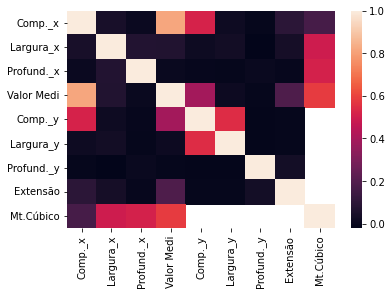

In [232]:
import seaborn as sns

sns.heatmap(df.corr())

In [233]:
# Avaliando missings:

df.isnull().sum()

Ordem              0
Operação_x         0
TSE Oper._x        0
Un. Adm.           0
Comp._x            0
Largura_x          0
Profund._x         0
StatSist_x         0
StatUsuár._x       0
Valor Medi         0
Operação_y         0
TSE Oper._y        0
Tipo Mat.          0
Pos. Rede          0
Diam.Rede          0
Diam.Ramal         0
Diam.Cavl.         0
Comp._y            0
Largura_y          0
Profund._y         0
Extensão           0
MND                0
Mt.Cúbico       1540
StatSist_y         0
StatUsuár._y       0
dtype: int64

In [234]:
# Replacing null values for 0:

df['Mt.Cúbico'] = df['Mt.Cúbico'].fillna(0)
df.isnull().sum()

Ordem           0
Operação_x      0
TSE Oper._x     0
Un. Adm.        0
Comp._x         0
Largura_x       0
Profund._x      0
StatSist_x      0
StatUsuár._x    0
Valor Medi      0
Operação_y      0
TSE Oper._y     0
Tipo Mat.       0
Pos. Rede       0
Diam.Rede       0
Diam.Ramal      0
Diam.Cavl.      0
Comp._y         0
Largura_y       0
Profund._y      0
Extensão        0
MND             0
Mt.Cúbico       0
StatSist_y      0
StatUsuár._y    0
dtype: int64

In [235]:
df.nunique()

Ordem           1523
Operação_x         7
TSE Oper._x        8
Un. Adm.           2
Comp._x          177
Largura_x        159
Profund._x         9
StatSist_x         2
StatUsuár._x       4
Valor Medi        55
Operação_y         1
TSE Oper._y       75
Tipo Mat.          5
Pos. Rede          6
Diam.Rede         11
Diam.Ramal         6
Diam.Cavl.         4
Comp._y           26
Largura_y         21
Profund._y        47
Extensão          29
MND                2
Mt.Cúbico          5
StatSist_y         2
StatUsuár._y       4
dtype: int64

In [236]:
df.columns

Index(['Ordem', 'Operação_x', 'TSE Oper._x', 'Un. Adm.', 'Comp._x',
       'Largura_x', 'Profund._x', 'StatSist_x', 'StatUsuár._x', 'Valor Medi',
       'Operação_y', 'TSE Oper._y', 'Tipo Mat.', 'Pos. Rede', 'Diam.Rede',
       'Diam.Ramal', 'Diam.Cavl.', 'Comp._y', 'Largura_y', 'Profund._y',
       'Extensão', 'MND', 'Mt.Cúbico', 'StatSist_y', 'StatUsuár._y'],
      dtype='object')

In [237]:
df['Diam.Ramal'].unique()

array([0, 'DN_20', 'DN_100', 'DN_200', 'DN_150', 'DN_32'], dtype=object)

In [238]:
df.dtypes

Ordem            object
Operação_x       object
TSE Oper._x      object
Un. Adm.         object
Comp._x         float64
Largura_x       float64
Profund._x      float64
StatSist_x       object
StatUsuár._x     object
Valor Medi      float64
Operação_y       object
TSE Oper._y      object
Tipo Mat.        object
Pos. Rede        object
Diam.Rede        object
Diam.Ramal       object
Diam.Cavl.       object
Comp._y         float64
Largura_y       float64
Profund._y      float64
Extensão        float64
MND              object
Mt.Cúbico       float64
StatSist_y       object
StatUsuár._y     object
dtype: object

In [239]:
# Removendo as variaveis desnecessarias:

df.drop(['Ordem', 'Operação_x', 'StatSist_x', 'Operação_y', 'StatSist_y', 'StatUsuár._y'], axis=1, inplace=True)
df.head()

,TSE Oper._x,Un. Adm.,Comp._x,Largura_x,Profund._x,StatUsuár._x,Valor Medi,TSE Oper._y,Tipo Mat.,Pos. Rede,Diam.Rede,Diam.Ramal,Diam.Cavl.,Comp._y,Largura_y,Profund._y,Extensão,MND,Mt.Cúbico
0,733000,277,1.0,1.0,0.0,EXEC VALO,108.56,286000,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0
1,904200,273,0.0,0.0,0.0,NEXE VALO,0.00,764500,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0
2,733000,277,2.0,1.5,0.0,EXEC VALO,108.56,286000,FF,TA,75,DN_20,0,0.0,0.0,0.6,0.0,Sim,0.0
3,733000,277,1.0,1.0,0.0,EXEC VALO,108.56,286000,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0
4,904200,273,0.0,0.0,0.0,NEXE VALO,0.00,734000,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0


In [240]:
# Separando o dataframe de teste:
# O dataframe de teste sera composto pelos servicos cujo estatos do usuario = EXEC ou NEXEC:

mask = df['StatUsuár._x'].isin(['EXEC', 'NEXE'])
teste = df[mask]
teste.head()

,TSE Oper._x,Un. Adm.,Comp._x,Largura_x,Profund._x,StatUsuár._x,Valor Medi,TSE Oper._y,Tipo Mat.,Pos. Rede,Diam.Rede,Diam.Ramal,Diam.Cavl.,Comp._y,Largura_y,Profund._y,Extensão,MND,Mt.Cúbico
390,733000,277,1.0,1.0,0.0,EXEC,139.58,280000,PEAD,TO,100,DN_20,0,0.0,0.0,1.0,0.0,Sim,0.0
416,733000,277,1.0,1.0,0.0,EXEC,139.58,280000,PEAD,TO,100,DN_20,0,0.0,0.0,1.0,0.0,Sim,0.0
509,733000,277,1.0,1.0,0.0,EXEC,69.21,280000,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0
697,733000,277,1.0,1.0,0.0,EXEC,139.58,280000,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0
699,733000,277,1.0,1.0,0.0,EXEC,139.58,280000,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0


In [241]:
# Separando o dataframe de treino:

mask = df['StatUsuár._x'].isin(['EXEC VALO', 'NEXE VALO'])
treino = df[mask]
treino.head()

,TSE Oper._x,Un. Adm.,Comp._x,Largura_x,Profund._x,StatUsuár._x,Valor Medi,TSE Oper._y,Tipo Mat.,Pos. Rede,Diam.Rede,Diam.Ramal,Diam.Cavl.,Comp._y,Largura_y,Profund._y,Extensão,MND,Mt.Cúbico
0,733000,277,1.0,1.0,0.0,EXEC VALO,108.56,286000,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0
1,904200,273,0.0,0.0,0.0,NEXE VALO,0.00,764500,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0
2,733000,277,2.0,1.5,0.0,EXEC VALO,108.56,286000,FF,TA,75,DN_20,0,0.0,0.0,0.6,0.0,Sim,0.0
3,733000,277,1.0,1.0,0.0,EXEC VALO,108.56,286000,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0
4,904200,273,0.0,0.0,0.0,NEXE VALO,0.00,734000,0,0,0,0,0,0.0,0.0,0.0,0.0,Não,0.0


In [242]:
# Agora que separamos o que ja foi pago do que ainda esta pendente, podemos descartar essa variavel:

teste.drop('StatUsuár._x', axis=1, inplace=True)

treino.drop('StatUsuár._x', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [243]:
df.columns

Index(['TSE Oper._x', 'Un. Adm.', 'Comp._x', 'Largura_x', 'Profund._x',
       'StatUsuár._x', 'Valor Medi', 'TSE Oper._y', 'Tipo Mat.', 'Pos. Rede',
       'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.', 'Comp._y', 'Largura_y',
       'Profund._y', 'Extensão', 'MND', 'Mt.Cúbico'],
      dtype='object')

In [244]:
teste.nunique()

TSE Oper._x     5
Un. Adm.        1
Comp._x        18
Largura_x      15
Profund._x      6
Valor Medi     13
TSE Oper._y    18
Tipo Mat.       5
Pos. Rede       5
Diam.Rede       6
Diam.Ramal      3
Diam.Cavl.      2
Comp._y         2
Largura_y       2
Profund._y      5
Extensão        5
MND             2
Mt.Cúbico       1
dtype: int64

In [245]:
#Variaveis com categoricas cardinalidade menor ou igual a 10, utilizamos o get_dummies:
#BASE TESTE

dum_teste = pd.get_dummies(teste,
                    columns=['TSE Oper._x', 'Un. Adm.', 'Tipo Mat.', 'Pos. Rede',
                             'Diam.Rede','Diam.Ramal', 'Diam.Cavl.', 'MND'],
                    drop_first=True,
                    prefix=['TSE', 'UnAdm', 'TipoMat', 'PosRede',
                            'DRede', 'DRamal', 'DCav', 'MND'],
                    prefix_sep='_')
dum_teste.head()

,Comp._x,Largura_x,Profund._x,Valor Medi,TSE Oper._y,Comp._y,Largura_y,Profund._y,Extensão,Mt.Cúbico,...,PosRede_TO,DRede_100,DRede_200,DRede_32,DRede_75,DRede_80,DRamal_DN_100,DRamal_DN_20,DCav_DN_20,MND_Sim
390,1.0,1.0,0.0,139.58,280000,0.0,0.0,1.0,0.0,0.0,...,1,1,0,0,0,0,0,1,0,1
416,1.0,1.0,0.0,139.58,280000,0.0,0.0,1.0,0.0,0.0,...,1,1,0,0,0,0,0,1,0,1
509,1.0,1.0,0.0,69.21,280000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
697,1.0,1.0,0.0,139.58,280000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
699,1.0,1.0,0.0,139.58,280000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [246]:
#Variaveis com categoricas cardinalidade menor ou igual a 10, utilizamos o get_dummies:
#BASE TESTE

dum_treino = pd.get_dummies(treino,
                    columns=['TSE Oper._x', 'Un. Adm.', 'Tipo Mat.', 'Pos. Rede',
                             'Diam.Rede','Diam.Ramal', 'Diam.Cavl.', 'MND'],
                    drop_first=True,
                    prefix=['TSE', 'UnAdm', 'TipoMat', 'PosRede',
                            'DRede', 'DRamal', 'DCav', 'MND'],
                    prefix_sep='_')
dum_treino.head()

,Comp._x,Largura_x,Profund._x,Valor Medi,TSE Oper._y,Comp._y,Largura_y,Profund._y,Extensão,Mt.Cúbico,...,DRede_80,DRamal_DN_100,DRamal_DN_150,DRamal_DN_20,DRamal_DN_200,DRamal_DN_32,DCav_DN_20,DCav_DN_50,DCav_DN_80,MND_Sim
0,1.0,1.0,0.0,108.56,286000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.00,764500,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1.5,0.0,108.56,286000,0.0,0.0,0.6,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
3,1.0,1.0,0.0,108.56,286000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.00,734000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [247]:
#Removendo index das dummies BASE_ANALITICA:
dum_treino.reset_index(drop=True, inplace=True)

#Removendo index das dummies BASE TESTE:
dum_teste.reset_index(drop=True, inplace=True)

In [248]:
dum_treino.head()

,Comp._x,Largura_x,Profund._x,Valor Medi,TSE Oper._y,Comp._y,Largura_y,Profund._y,Extensão,Mt.Cúbico,...,DRede_80,DRamal_DN_100,DRamal_DN_150,DRamal_DN_20,DRamal_DN_200,DRamal_DN_32,DCav_DN_20,DCav_DN_50,DCav_DN_80,MND_Sim
0,1.0,1.0,0.0,108.56,286000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.00,764500,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1.5,0.0,108.56,286000,0.0,0.0,0.6,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
3,1.0,1.0,0.0,108.56,286000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.00,734000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [249]:
dum_teste.head()

,Comp._x,Largura_x,Profund._x,Valor Medi,TSE Oper._y,Comp._y,Largura_y,Profund._y,Extensão,Mt.Cúbico,...,PosRede_TO,DRede_100,DRede_200,DRede_32,DRede_75,DRede_80,DRamal_DN_100,DRamal_DN_20,DCav_DN_20,MND_Sim
0,1.0,1.0,0.0,139.58,280000,0.0,0.0,1.0,0.0,0.0,...,1,1,0,0,0,0,0,1,0,1
1,1.0,1.0,0.0,139.58,280000,0.0,0.0,1.0,0.0,0.0,...,1,1,0,0,0,0,0,1,0,1
2,1.0,1.0,0.0,69.21,280000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,0.0,139.58,280000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,0.0,139.58,280000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [250]:
teste.nunique()

TSE Oper._x     5
Un. Adm.        1
Comp._x        18
Largura_x      15
Profund._x      6
Valor Medi     13
TSE Oper._y    18
Tipo Mat.       5
Pos. Rede       5
Diam.Rede       6
Diam.Ramal      3
Diam.Cavl.      2
Comp._y         2
Largura_y       2
Profund._y      5
Extensão        5
MND             2
Mt.Cúbico       1
dtype: int64

In [251]:
#Variaveis com cardinalidade maior que 10, utilizamos o Label Encoder:
#BASE TESTE

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le_TSE = le.fit_transform(dum_teste['TSE Oper._y'])
le_TSE_df = pd.DataFrame(le_TSE, columns=['LE_TSE'])

teste = pd.merge(dum_teste, le_TSE_df, left_index=True, right_index=True)

In [252]:
#Variaveis com cardinalidade maior que 10, utilizamos o Label Encoder:
#BASE TREINO

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le_TSE = le.fit_transform(dum_treino['TSE Oper._y'])
le_TSE_df = pd.DataFrame(le_TSE, columns=['LE_TSE'])

treino = pd.merge(dum_treino, le_TSE_df, left_index=True, right_index=True)

In [253]:
#Vamos separar as variaveis explicativas da Target:
#BASE TESTE
teste.columns

Index(['Comp._x', 'Largura_x', 'Profund._x', 'Valor Medi', 'TSE Oper._y',
       'Comp._y', 'Largura_y', 'Profund._y', 'Extensão', 'Mt.Cúbico',
       'TSE_733000', 'TSE_743000', 'TSE_745000', 'TSE_901500',
       'TipoMat_CERAMICO', 'TipoMat_FF', 'TipoMat_PEAD', 'TipoMat_PVC',
       'PosRede_EI', 'PosRede_PO', 'PosRede_TA', 'PosRede_TO', 'DRede_100',
       'DRede_200', 'DRede_32', 'DRede_75', 'DRede_80', 'DRamal_DN_100',
       'DRamal_DN_20', 'DCav_DN_20', 'MND_Sim', 'LE_TSE'],
      dtype='object')

In [254]:
# Selecao de variaveis:
#BASE TESTE

explicativas_teste = teste[['Comp._x', 'Largura_x', 'Profund._x', 'TSE Oper._y',
       'Comp._y', 'Largura_y', 'Profund._y', 'Extensão', 'Mt.Cúbico',
       'TSE_733000', 'TSE_743000', 'TSE_745000', 'TSE_901500',
       'TipoMat_CERAMICO', 'TipoMat_FF', 'TipoMat_PEAD', 'TipoMat_PVC',
       'PosRede_EI', 'PosRede_PO', 'PosRede_TA', 'PosRede_TO', 'DRede_100',
       'DRede_200', 'DRede_32', 'DRede_75', 'DRede_80', 'DRamal_DN_100',
       'DRamal_DN_20', 'DCav_DN_20', 'MND_Sim', 'LE_TSE']]

target_teste = teste[['Valor Medi']]

In [255]:
# Selecao de variaveis:
#BASE TREINO

explicativas_treino = treino[['Comp._x', 'Largura_x', 'Profund._x', 'TSE Oper._y',
       'Comp._y', 'Largura_y', 'Profund._y', 'Extensão', 'Mt.Cúbico',
       'TSE_733000', 'TSE_743000', 'TSE_745000', 'TSE_901500',
       'TipoMat_CERAMICO', 'TipoMat_FF', 'TipoMat_PEAD', 'TipoMat_PVC',
       'PosRede_EI', 'PosRede_PO', 'PosRede_TA', 'PosRede_TO', 'DRede_100',
       'DRede_200', 'DRede_32', 'DRede_75', 'DRede_80', 'DRamal_DN_100',
       'DRamal_DN_20', 'DCav_DN_20', 'MND_Sim', 'LE_TSE']]

target_treino = treino[['Valor Medi']]

In [256]:
treino.isnull().sum()

Comp._x             0
Largura_x           0
Profund._x          0
Valor Medi          0
TSE Oper._y         0
Comp._y             0
Largura_y           0
Profund._y          0
Extensão            0
Mt.Cúbico           0
TSE_732000          0
TSE_733000          0
TSE_743000          0
TSE_745000          0
TSE_901500          0
TSE_903000          0
TSE_904200          0
UnAdm_277           0
TipoMat_CERAMICO    0
TipoMat_FF          0
TipoMat_PEAD        0
TipoMat_PVC         0
PosRede_EI          0
PosRede_PA          0
PosRede_PO          0
PosRede_TA          0
PosRede_TO          0
DRede_100           0
DRede_150           0
DRede_200           0
DRede_250           0
DRede_300           0
DRede_32            0
DRede_400           0
DRede_63            0
DRede_75            0
DRede_80            0
DRamal_DN_100       0
DRamal_DN_150       0
DRamal_DN_20        0
DRamal_DN_200       0
DRamal_DN_32        0
DCav_DN_20          0
DCav_DN_50          0
DCav_DN_80          0
MND_Sim   

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544 entries, 0 to 1543
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TSE Oper._x   1544 non-null   object 
 1   Un. Adm.      1544 non-null   object 
 2   Comp._x       1544 non-null   float64
 3   Largura_x     1544 non-null   float64
 4   Profund._x    1544 non-null   float64
 5   StatUsuár._x  1544 non-null   object 
 6   Valor Medi    1544 non-null   float64
 7   TSE Oper._y   1544 non-null   object 
 8   Tipo Mat.     1544 non-null   object 
 9   Pos. Rede     1544 non-null   object 
 10  Diam.Rede     1544 non-null   object 
 11  Diam.Ramal    1544 non-null   object 
 12  Diam.Cavl.    1544 non-null   object 
 13  Comp._y       1544 non-null   float64
 14  Largura_y     1544 non-null   float64
 15  Profund._y    1544 non-null   float64
 16  Extensão      1544 non-null   float64
 17  MND           1544 non-null   object 
 18  Mt.Cúbico     1544 non-null 

In [258]:
# Grid Search:

# Modelagem com GridSearch e CrossValidation K-fold:

x_train, x_test, y_train, y_test = train_test_split(explicativas_treino, target_treino, test_size=0.3, random_state=42)

In [259]:
# Estanciando os modelos com as vairacoes de hiperparametros nos dicionarios:

from sklearn.tree import DecisionTreeRegressor

modelo_dt = DecisionTreeRegressor(random_state=42)

grid_dt = {
    "max_depth": [1, 3, 5, 8],
    "criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"]
}

In [260]:
#GridSearch CV da Regressão Logística:

grid_dt= GridSearchCV(modelo_dt,
                      grid_dt,
                      scoring='accuracy',
                      cv=10)

In [261]:
#Treinando o modelo de Regressão Logística:
grid_dt.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 3, 5, 8]},
             scoring='accuracy')

In [262]:
grid_dt.predict(x_test)

array([  157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
      

In [263]:
grid_dt.predict(explicativas_teste)

array([  157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
       19594.67666667,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
         157.78985149,   157.78985149,   157.78985149,   157.78985149,
      

In [264]:
y_test

,Valor Medi
1036,216.61
1124,108.56
997,0.00
1316,109.02
529,109.02
...,...
535,139.58
135,0.00
756,139.58
561,139.58


In [265]:
x_test

,Comp._x,Largura_x,Profund._x,TSE Oper._y,Comp._y,Largura_y,Profund._y,Extensão,Mt.Cúbico,TSE_733000,...,DRede_100,DRede_200,DRede_32,DRede_75,DRede_80,DRamal_DN_100,DRamal_DN_20,DCav_DN_20,MND_Sim,LE_TSE
1036,5.00,1.50,0.04,732000,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,58
1124,2.00,2.00,0.04,284500,0.0,0.0,1.0,0.0,0.0,0,...,1,0,0,0,0,0,1,0,1,10
997,1.20,1.00,0.00,416000,0.0,0.0,1.0,0.0,0.0,0,...,0,0,0,1,0,0,1,0,0,30
1316,1.20,1.00,0.04,284500,0.0,0.0,70.0,0.0,0.0,0,...,0,0,0,1,0,0,1,0,1,10
529,1.20,1.00,0.04,734000,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,1.00,1.00,0.00,280000,0.0,0.0,1.0,0.0,0.0,1,...,1,0,0,0,0,0,1,0,1,6
135,3.60,6.70,0.04,732000,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,58
756,0.65,0.55,0.00,254000,0.0,0.0,1.0,0.0,0.0,1,...,0,0,0,1,0,0,1,1,1,2
561,1.30,0.60,0.00,734000,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,60


In [266]:
explicativas_teste.head()

,Comp._x,Largura_x,Profund._x,TSE Oper._y,Comp._y,Largura_y,Profund._y,Extensão,Mt.Cúbico,TSE_733000,...,DRede_100,DRede_200,DRede_32,DRede_75,DRede_80,DRamal_DN_100,DRamal_DN_20,DCav_DN_20,MND_Sim,LE_TSE
0,1.0,1.0,0.0,280000,0.0,0.0,1.0,0.0,0.0,1,...,1,0,0,0,0,0,1,0,1,1
1,1.0,1.0,0.0,280000,0.0,0.0,1.0,0.0,0.0,1,...,1,0,0,0,0,0,1,0,1,1
2,1.0,1.0,0.0,280000,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,1
3,1.0,1.0,0.0,280000,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,1
4,1.0,1.0,0.0,280000,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,1


In [267]:
grid_dt.best_params_

{'criterion': 'squared_error', 'max_depth': 1}

In [268]:
# Estanciando os modelos com as vairacoes de hiperparametros nos dicionarios:

from sklearn.ensemble import RandomForestRegressor

modelo_rf = RandomForestRegressor(random_state=42)

grid_rf = {
    "max_depth": [1, 3, 5, 8],
    "criterion":["squared_error", "absolute_error", "poisson"]
}

In [269]:
#GridSearch CV do Random Forest:

grid_rf= GridSearchCV(modelo_rf,
                      grid_rf,
                      scoring='accuracy',
                      cv=10)

In [270]:
#Treinando o modelo de Random Forest:

grid_rf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_depth': [1, 3, 5, 8]},
             scoring='accuracy')

In [271]:
grid_rf.predict(x_test)

array([  158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
      

In [272]:
grid_rf.predict(explicativas_teste)

array([  158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
       16909.6586508 ,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
         158.34864031,   158.34864031,   158.34864031,   158.34864031,
      

In [273]:
len(explicativas_teste)

92

In [274]:
# Estanciando os modelos com as vairacoes de hiperparametros nos dicionarios:

from sklearn.ensemble import GradientBoostingRegressor

modelo_gb = GradientBoostingRegressor(random_state=42)

grid_gb = {
    "max_depth": [1, 3, 5, 8],
    "criterion":["friedman_mse", "squared_error", "mse"]
}

In [275]:
#GridSearch CV do Gradient Boosting Regressor:

grid_gb= GridSearchCV(modelo_gb,
                      grid_gb,
                      scoring='accuracy',
                      cv=10)

In [276]:
# Treinando o modelo de Gradient Boosting:

grid_gb.fit(x_test, y_test)

A saída de streaming foi truncada nas últimas 5000 linhas.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/loc

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'criterion': ['friedman_mse', 'squared_error', 'mse'],
                         'max_depth': [1, 3, 5, 8]},
             scoring='accuracy')

In [277]:
grid_gb.predict(x_test)

array([  945.84515548,    95.941311  ,    95.941311  ,    95.941311  ,
         120.08859379,   201.70974329,   302.47886626,   120.08859379,
         302.47886626,   201.70974329,   201.70974329,   120.08859379,
          95.941311  ,   201.70974329,    95.941311  ,    95.941311  ,
         120.08859379,    95.941311  ,   201.70974329,    95.941311  ,
          95.941311  ,  1051.61358777,   220.85771676,    95.941311  ,
          95.941311  ,    95.941311  ,    95.941311  ,   201.70974329,
          95.941311  ,   201.70974329,    95.941311  ,    95.941311  ,
         969.99243827,    95.941311  ,  1474.80678241,   225.85702609,
          95.941311  ,   201.70974329,    95.941311  ,    95.941311  ,
         225.85702609,    95.941311  ,    95.941311  ,    95.941311  ,
         225.85702609,   120.08859379,   225.85702609,   302.47886626,
         225.85702609,    95.941311  ,    95.941311  ,   120.08859379,
         196.71043397,   201.70974329,   120.08859379,    95.941311  ,
      

In [278]:
grid_gb.predict(explicativas_teste)

array([ 201.70974329,  201.70974329,  201.70974329,  201.70974329,
        201.70974329,  201.70974329,  201.70974329,  201.70974329,
        201.70974329,   95.941311  ,   95.941311  ,  201.70974329,
        201.70974329,  201.70974329,  201.70974329,  201.70974329,
        201.70974329,  201.70974329,  201.70974329,  201.70974329,
        945.84515548, 1051.61358777,  201.70974329,  302.47886626,
         95.941311  ,   95.941311  ,   95.941311  ,  201.70974329,
        201.70974329,  201.70974329,  201.70974329,   95.941311  ,
         95.941311  ,  201.70974329,  201.70974329,  201.70974329,
         95.941311  ,   95.941311  ,   95.941311  ,   95.941311  ,
        201.70974329,   95.941311  ,   95.941311  ,   95.941311  ,
         95.941311  ,  201.70974329,  196.71043397,   95.941311  ,
        201.70974329,   95.941311  ,   95.941311  , 1051.61358777,
         95.941311  ,   95.941311  ,   95.941311  ,   95.941311  ,
         95.941311  ,   95.941311  ,   95.941311  ,   95.94131

In [281]:
# Estanciando os modelos com as vairacoes de hiperparametros nos dicionarios:

from sklearn.neighbors import KNeighborsRegressor

modelo_kn = KNeighborsRegressor()

grid_kn = {
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "weights":["uniform", "distance"]
}

In [282]:
grid_kn = GridSearchCV(modelo_kn,
                         grid_kn,
                         cv=10,
                       scoring='accuracy')

In [283]:
grid_kn.fit(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [284]:
grid_kn.predict(x_test)

array([[  86.644],
       [ 108.836],
       [   0.   ],
       [ 108.928],
       [ 261.732],
       [ 139.58 ],
       [ 624.97 ],
       [   0.   ],
       [ 619.844],
       [ 139.58 ],
       [ 139.58 ],
       [   0.   ],
       [   0.   ],
       [  21.804],
       [ 216.61 ],
       [  41.528],
       [   0.   ],
       [   0.   ],
       [ 127.264],
       [   0.   ],
       [  37.006],
       [ 209.432],
       [  43.608],
       [   0.   ],
       [  25.12 ],
       [   0.   ],
       [  21.804],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [   0.   ],
       [ 155.344],
       [3941.838],
       [   0.   ],
       [3082.072],
       [ 139.58 ],
       [  62.8  ],
       [   0.   ],
       [ 216.61 ],
       [  62.8  ],
       [ 227.3  ],
       [  20.764],
       [   0.   ],
       [   0.   ],
       [ 111.664],
       [ 261.732],
       [  43.608],
       [ 435.272],
       [ 139.58 ],
       [   0.   ],
       [ 108.56 ],
       [ 133.468],
       [ 656

In [286]:
grid_kn.predict(explicativas_teste)

array([[ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [3928.764],
       [ 603.182],
       [ 606.77 ],
       [ 602.154],
       [   0.   ],
       [ 209.432],
       [   0.   ],
       [ 209.432],
       [ 139.58 ],
       [ 139.58 ],
       [ 139.58 ],
       [   0.   ],
       [ 155.344],
       [  21.804],
       [ 139.58 ],
       [ 139.58 ],
       [   0.   ],
       [   0.   ],
       [   0.   ],
       [   0.   ],
       [ 139.58 ],
       [ 216.61 ],
       [ 356.062],
       [   0.   ],
       [   0.   ],
       [ 139.58 ],
       [   0.   ],
       [  87.124],
       [ 139.58 ],
       [ 209.432],
       [ 209.432],
       [ 155.344],
       [ 139